## Tutorial - Time Series Prediction with Recurrent nets

## Objective

**Time series analysis with recurrent nets**: 

The goal would be to learn how different recurrent neural networks can be used for predicting future values in a time series based on knowledge from the past values. Also, to check how different recurrent models of varying complexity perform with respect to the prediction task. 

In this notebook, a dataset known as 'dynamo_esn' is used, which is a simulated version of the number of sunspots on the Sun's surface recorded over time.

## Exercises

- Complete a part of the code for fitting an Echo state network (ESN) on the data. The ESN can be considered as a baseline reference for the neural network models.
- Complete the code to train a particular recurrent neural network (LSTM/GRU) on time series data.
- Try to run the code for training another one of three models (such as LSTM) for comparing predictions for a given cycle.

### Additionally:
- Try to tune the model hyperparameters for LSTM to see if a better result can be obtained for the given model prediction. Insert some new code after this part, by reusing the existing code and experiment with the 
model `options` such `n_layers` or `n_hidden`, etc.

- *(Optional)* **Checking the variance of the predictions**: Try to simulate the GRU model training many times (set the verbosity flag to False), and plot a figure that shows how the mean prediction across the number of simulations and the standard deviation of the predictions. Compare it with the actual test prediction.

##  References

- PyTorch Recurrent layers (from `torch.nn.Module`):
    - [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)
    - [nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU)

### Import necessary libraries

In [ ]:
# Import the necessary libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import torch
import copy
from torch import nn, optim
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import json
import itertools
import argparse
from argparse import RawTextHelpFormatter

### Connecting to GPU:

- This notebook uitilizes the computational power of GPUs for faster execution. In case your computers have GPU support or access to GPU servers, you do not need to execute this notebook on Google Colab.

Otherwise, if you choose to use Google Colab the following steps follow:

- In order to facilitate the use of GPUs in Google Colab (owing to large no. of parameters in the models), firstly you can connect to the GPU by going to *Edit* ---> *Notebook settings* ---> Select *Hardware accelerator* as *GPU*. The notebook will reconnect once and will now be connected to the GPU given by Google Colab. If the setting is not changed, then the codes will be executed using CPU.

  You can check the GPU status by executing the command in the following cell to check available GPU memory and stats.

  ```
  !/opt/bin/nvidia-smi # '!' is used to access command line
  ```

In [ ]:
!/opt/bin/nvidia-smi # '!' is used to access command line

Mon Feb 15 17:25:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing and Loading the Dataset: 


In [ ]:
ngpu = 1 # Comment this out if you want to run on cpu and the next line just set device to "cpu"
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu>0) else "cpu")
print("Device Used:{}".format(device))

Device Used:cuda:0


## Loading the data

### Importing functions relevant to the dataset


In [1]:
from utils import *

### Importing the dataset

The dataset used for the time-series problem is a *simulated* version of a time-series representing solar cycles.

- A **solar cycle** or solar magnetic activity cycle is approximately a periodic change in solar activity measured in terms of variations in the no. of observed sunspots on the Sun's surface. The goal is to try training a recurrent neural network to predict the number of sunspots in a future cycle using the data available from the past solar cycles. 
- `dynamo_esn.txt` represents 1-dimensional solar cycle data that is **synthetically generated** through simulation (solving a differential equation). 
- The time indices that represent *months*. The vertical axis measures solar cycle activity in terms of number of sunspots. So the data is *number of sunspots* vs. *months*.
- One **solar cycle** approximately corresponds to 11 years. A **cycle** is considered as a set of points that go from a minimum to the next maximum.


In [ ]:
# In case of importing from Google Drive (mention that path), else
# comment out these three lines. You might be required to put the value of an 
# authentication token while connecting your google drive to Colab
from google.colab import drive
drive.mount('/content/drive')
train_file = "/content/drive/My Drive/dynamo_esn.txt" 

# In case of running the code from your local machine, so you provide the path to 
# the data file instead of importing through google colab

# train_file = "./dynamo_esn.txt" 

# Mention the type of the dataset
dataset = "dynamo"
data = np.loadtxt(train_file) # Loads the data into a numpy array 

# Keep a copy of the unnormalized data for plotting purposes later on
unnormalized_data = copy.deepcopy(data)

# Normalizing the input data in the range of [0, 1] before feeding it 
# to the machine learning models
data[:, 1], Xmax, Xmin = normalize(X=data[:, 1], feature_space=(0, 1))

Mounted at /content/drive


Obtain a set of indices that indicate the starting points of the solar cycle.
A solar cycle is considered as the set of points between two consecutive local minima of the data

In [ ]:
minimum_idx = get_minimum(data, dataset)

### Plotting the time-series data

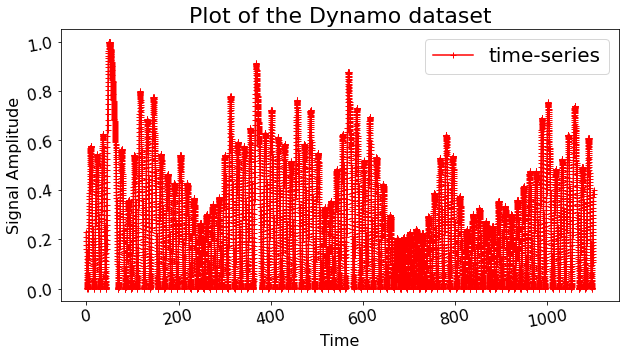

In [ ]:
plt.figure(figsize=(10,5))
#plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data[:, 0], data[:, 1], '+-', color='red', label='time-series')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Signal Amplitude', fontsize=16)
plt.xticks(fontsize=16, rotation=10)
plt.yticks(fontsize=16, rotation=10)
plt.title("Plot of the Dynamo dataset", fontsize=22)
plt.legend(fontsize=20)
plt.show()

## Using an Echo state network (ESN) for modeling the data

We define some helper functions for coding the class for ESN. Subsequently, we define the class for the Echo state network

In [ ]:
# Define some helper functions
def build_history_vector(x, index_n, p):
    """ Building the history vector ('yn')

    Args:
        x ([numpy.ndarray]): time series as a training signal
        indexn ([int]): the index n
        histo_size ([int]): the length of feedback vector

    Returns:
        yn ([torch.Tensor]): the list containing the set of time-series values
                            as feedback vector    
    """
    yn = torch.zeros(p)
    for i in range(p):
        if index_n-i < 0:
            print("encountered negative index when building yn")
            sys.exit()
        yn[i] = x[index_n-i]
    return yn

def build_reservoir(num_neur, conn_per_neur, spec_rad):
    """ Building reservoir matrix using random connections and values sampled from N(0, I)
    """
    Wres = np.zeros((num_neur, num_neur))
    for i in range(num_neur):
        random_columns = np.random.randint(0, num_neur, conn_per_neur)
        for j in random_columns:
            Wres[i, j] = np.random.normal(scale=1)
    Wres = torch.from_numpy(change_spectral_radius(Wres, spec_rad)).type(torch.FloatTensor)
    return Wres

def build_Wfb(num_neur, yn_size_p, spec_rad):
    """ Building a feedback matrix 
    """
    Wfb = np.random.normal(scale=1, size=(num_neur, yn_size_p))
    U, S, VH = np.linalg.svd(Wfb) #S contains the sqrt of eigenvs of Wfb*WfbH 
    Wfb = Wfb * np.sqrt(spec_rad) / np.max(S)
    #now the max eigenv of Wfb*(Wfb)T is equal to spec_rad 
    Wfb = torch.from_numpy(Wfb).type(torch.FloatTensor)
    return Wfb
    
def change_spectral_radius(Wres, new_radius):
    """ Adjust spectral radius of the reservoir matrices
    """
    eigenvalues = np.linalg.eig(Wres)[0]
    max_absolute_eigen = np.max(np.absolute(eigenvalues))
    return Wres * new_radius/max_absolute_eigen

Defining the ESN class. Here, the class is referred to as `NovelESN` because of some variations e.g. with step-ahead predictions and a *teacher forcing* using the input. 

Task:
- Complete the `update_state` function that basically updates the hidden state of the ESN using the equation:

  $\mathbf{h}_{n+1} = \tanh(\mathbf{W}_{res} \cdot \mathbf{h}_{n} + \mathbf{W}_{fb} \cdot \mathbf{x}_{n})$

In [ ]:
class NovelESN(nn.Module):
    """ This class defines the model for Novel Echo state network
    """
    def __init__(self, num_neur=1000, conn_per_neur=10,
                spectr_rad=0.8, tau=151, history_q=152, history_p=32,
                beta_regularizer=1e-10, lr=1e-3):
        """
        Initializing the model parameters:

        - num_neur: No. of neurons
        - conn_per_neur: Number of connections per neuron
        - spectr_rad: Spectral Radius required for the non-trainable matrices
        - tau: Defines the index for predicting future samples
        - history_q: Starting from the index 'tau' how many steps to predict behind 
                     (jump to 'tau' and then predict 'history_q' values behind)
        - history_p: No. of values of taken in from the time-series as a feedback vector
        - beta_regularizer: Value of beta used for regularization (L2) of the weights
        - lr: Learning rate to be used
        """
        self.num_neur = num_neur
        self.xstate = torch.zeros((num_neur))
        self.history_p = history_p
        self.history_q = history_q
        self.spectral_rad = spectr_rad
        self.Wfb = build_Wfb(self.num_neur, self.history_p, self.spectral_rad).requires_grad_(False)
        self.tau = tau
        self.Wres = build_reservoir(num_neur, conn_per_neur, self.spectral_rad).requires_grad_(False)
        self.beta_regularizer = beta_regularizer
        self.lr = lr
    
    def init_output_linear_layer(self, input_size, output_size):
        """
        Constructs the output layer of the ESN architecture, here we assume that the
        output of the ESN is y_t = W_out * h_t + b_out, i.e. without any output non-linear 
        activate function
        """
        net_out = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=output_size, bias=True)
        )
        return net_out
    
    def teacher_forcing(self, x):
        """ This function uses teacher forcing, i.e. samples using the training signal
        to calculate a list of hidden states before passing it to train the output
        linear layer

        Args:
        - x: The training signal
        Returns:
        - Xstates: A torch tensor containing the predicted hidden states across 
        different time stamps
        """
        #we will save the training data for the predict function
        self.x = torch.Tensor(x) 
        self.N = len(x)
        
        # min index to build the first y_{n}
        nstart = self.history_p - 1 

        # Initially this vector contains values from index p-1 to p
        yn = build_history_vector(self.x, nstart, self.history_p)
        # we have the pairs y_{p-1}, x_{p-1}, where x_{p-1} = 0 (transcient)
        
        # Computes the value of x_{p} from x_{p-1}, y_{p-1}, W_res, W_fb
        # Updated value of x_{p} is saved as self.xstate
        # After the update we have the state x_{p}, we will save states from here 
        self.update_state(yn) 
        
        num_saved = 0 # Counter to count number of saved states

        # States x are saved from index n=p to n=N-1, 
        # a total of N-p saved states
        num_states = self.N - self.history_p

        # Initializee a numpy matrix to save states x_{n}
        # from n=p to n=N-1
        Xstates = torch.zeros((num_states, self.num_neur))
        
        for n in range(self.history_p, self.N):
            
            #we update yn to pair xn, to create a list of N-p values of y_{n} (for feedback)
            yn = torch.roll(yn, shifts=1)
            yn[0] = self.x[n]
            
            #yn.appendleft(train_signal[n]) 
            
            #print(n, self.xstate.shape)
            #xn is already ready
            Xstates[num_saved, :] = self.xstate.reshape((-1,)) #save
            
            # counter updated
            num_saved += 1 
            
            # This updates the value of self.xstate using new value
            # of yn (feedback vector), and self.xstate
            self.update_state(yn)

        #after the loop we have the final state x_{N}, not saved in Xstates
        # So, self.Xstates only contains values from x_{p-1} to x_{N-1}.
        self.Xstates = Xstates #the function predict will need the Xstates
        
        return Xstates
    
    def train(self, x, num_epochs = 30):
        """ This function optimizes the output parameters of ESN viz. W_out, b.
        This is achieved by solving a ridge regression problem using the 
        predictions from the reservoir and actual outputs

        Args:
            train_signal ([numpy.ndarray]): time series used as training data
        
        Returns:
            train_mse: Mean squared error obtained during training (after fitting)
        """
        #tau, q and p have conditions that the user must respect
        self.check_tau_q_and_p() 

        # Builds a matrix of dimension N-tau-p x q s.t.
        # Y_{n+tau}^{q} = [y_{p+tau}, y_{p+tau+1}, ..., y_{N-1}], 
        # with each y_{i} of dimension q x 1, and there are in total 
        # N-tau-p such training examples
        YntauVects = self.buildYntauVectors() 

        # Number of samples to be considered for training, which is equal
        # to N-tau-p
        num_vects = YntauVects.shape[0]

        #NOTE: self.Xstates contains N-p number of values already computed, 
        # so we take only N-p-tau values from the larger set of reservoir 
        # states to create our training data
        XstatesTrain = self.Xstates[0:num_vects, :] 
        
        # XstatesTrain and YntauVects must have the same number of vectors
        # for training
        #NOTE: Introduce a training using Adam

        # Initialize the output linear layer
        net_out = self.init_output_linear_layer(input_size=XstatesTrain.shape[1], 
                                         output_size=YntauVects.shape[1])
        
        optimizer_esn = torch.optim.Adam(net_out.parameters(), lr=self.lr, weight_decay=self.beta_regularizer)
        criterion = nn.MSELoss()
        losses = []
        tr_verbose = True
        #val_losses = []
        
        # Training loop
        for epoch in range(num_epochs):
        
            optimizer_esn.zero_grad()
            X = Variable(XstatesTrain, requires_grad=False).type(torch.FloatTensor)
            tr_predictions = net_out(X)
            tr_loss = criterion(tr_predictions, YntauVects)
            tr_loss.backward(retain_graph=True)
            optimizer_esn.step()

            losses.append(tr_loss.item())

            #with torch.no_grad():

             #   val_predictions = net_out(val_inputs)
             #   val_loss = criterion(val_predictions, val_targets)
             #   val_losses.append(val_loss.item())

            if tr_verbose == True and (((epoch + 1) % 50) == 0 or epoch == 0):
                print("Epoch: {}/{}, Training MSE Loss:{:.9f}".format(epoch+1, 
                num_epochs, tr_loss))

        return losses, net_out
        
        #self.reg_model, train_mse = solve_ridge_regr(XstatesTrain, YntauVects, 
        #                                                            self.beta)

        #return train_mse

    def predict(self, net_out):
        """ This function performs prediction for Echo State Network (ESN)
        using the trained regression model

        Returns:
            ypredNtau ([numpy.ndarray]): No. of steps to predict
            pred_indexes ([numpy.ndarray]): array of indices for predicting
            values
        """
        
        self.xstate = self.xstate.reshape((-1,))
        with torch.no_grad():
            ypredNtau = net_out(self.xstate)
            ypredNtau = torch.flipud(ypredNtau)
        
        #ypredNtau = self.reg_model.predict([self.xstate])[0] #xstate is x_N
        #ypredNtau = np.flip(ypredNtau) #we want indexes progress as time does
        
        # Create prediction indices
        index_last_pred = self.N + self.tau # = M+tau
        index_first_pred = index_last_pred - (self.history_q - 1) # = M+tau-(q-1)
        pred_indexes = np.arange(index_first_pred, index_last_pred + 1)
        
        # Convert torch tensor to numpy
        ypredNtau = ypredNtau.numpy()
        
        return ypredNtau, pred_indexes #ypred_{N+tau}
    
    
    def buildYntauVectors(self):
        """ Build a list of target vectors for regression

        Returns:
            YntauVects [(numpy.ndarray)]: Matrix of prediction values ((N-tau-p) x q)
            [num_samples x dimension of 'yntau']
        """
        nstart = self.history_p - 1 #the pairs xn, yn started at p-1
        yntau = build_history_vector(self.x, nstart + self.tau, 
                                    self.history_q)
        # n will go from p to N-tau-1, because we go tau in the future
        num_vects = self.N - self.tau - self.history_p
        YntauVects = torch.zeros((num_vects, self.history_q))
        num_saved = 0
        for n in range(self.history_p, self.N - self.tau):    
            # Shift the array
            yntau = torch.roll(yntau, shifts=1)
            yntau[0] = self.x[n+self.tau]
            
            #yntau.appendleft(self.x[n + self.tau])
            
            YntauVects[num_saved, :] = yntau
            num_saved += 1
        return YntauVects #y_{n+tau} vectors between n=p to n=N-tau-1 
    
    def update_state(self, xn):
        """ This function computes the value of the next reservoir state
        using the current value of the reservoir state h_{n} and 
        the corresponding value of the current input x_{n} by:
        
        Task:
        h_{n+1} = tanh(W_res @ h_{n} + W_fb @ x_{n})

        h_{n} is stored in self.xstate. This function rewrites the 
        value of self.xstate with h_{n+1}

        Args:
            xn (numpy.array): Input sequence
        
        Returns: 
            None (self.xstate gets overridden with new result)
        """
        
        # Write your code here
        self.xstate = torch.matmul(self.Wres, self.xstate).reshape(-1, 1) + torch.matmul(self.Wfb, xn).reshape(-1, 1)
        self.xstate = torch.tanh(self.xstate)
        return

  
    def check_tau_q_and_p(self):
        """ This function checks whether the value of q and tau
        are same or not. Also checks if the value of p + tau is
        lower than the training signal length
        """
        if self.tau < self.history_q-1:
            print("q is too big for the given tau")
            sys.exit("")
        if self.history_p + self.tau > self.N - 1:
            print("p + tau must be lower than the train signal length")
            sys.exit()
        return

### Training and making predictions using the ESN model

In [ ]:
# Training and Prediction using ESN
def train_and_predict_ESN(model, num_epochs, train_data, test_data=None):
    """ This function is used for calling the functions for training and 
    predicting the unseen cycle

    Args:
    - model: The object of the NovelESN class used for prediction
    - num_epochs: Number of epochs used for training the ESN model
    - train_data: The training data which contains both the time-instants in the
    first column, and the actual data in the second columns
    - test_data: The testing data which contains both the time-instants in the
    first column, and the actual data in the second columns
  
    Returns:
    - predictions_esn: The predicted values using the ESN model for the unseen 
    cycle / test cycle
    - te_data_signal: The actual values of the test cycle
    - pred_indexes: The time instants of the test cycle
    """
    
    if not (test_data is None) and len(test_data) > 0: # In case the 'future' cycle is still within the dataset
        
        # Get the training and testing signals
        tr_data_signal = train_data[:, -1].reshape((-1, 1))
        te_data_signal = test_data[:, -1].reshape((-1, 1))
      
        # Compute the static hidden layer output
        model.teacher_forcing(tr_data_signal)
        
        # Training the model 
        train_mse_vec, net_out = model.train(tr_data_signal, num_epochs)
        
        # Predictions using the model and check test error
        predictions_esn, pred_indexes = model.predict(net_out)
        test_mse = mean_squared_error(te_data_signal, predictions_esn)
        
        print("*************************************************************** \n")
        print("{} - {},  {} - {:.8f},  {} - {:.8f}".format("Model", "ESN",
                                                            "Training Error",
                                                            train_mse_vec[-1],
                                                            "Test Error",
                                                            test_mse))
        
    else: # In case the 'future' cycle is not within the dataset

        # Get the training and testing signals
        tr_data_signal = train_data[:, -1].reshape((-1, 1))

        # As the future cycle is not within the dataset
        te_data_signal = None
        
        # Compute the static hidden layer output
        model.teacher_forcing(tr_data_signal)

        # Training the model 
        train_mse_vec, net_out = model.train(tr_data_signal, num_epochs)
        
        # Predictions using the model 
        predictions_esn, pred_indexes = model.predict(net_out)
        test_mse = np.nan # As there is no true reference to compare to

        print("*************************************************************** \n")
        print("{} - {},  {} - {:.8f},  {} - {:.8f}".format("Model", "ESN",
                                                            "Training Error",
                                                            train_mse_vec[-1],
                                                            "Test Error",
                                                            test_mse))

    return predictions_esn, te_data_signal, pred_indexes

### Loading the data for making predictions using ESN model

In [ ]:
# Get the data (More details about the cycles are provided in the section where the
# RNN models are used)
X, Y = get_msah_training_dataset(data, minimum_idx=minimum_idx, tau=1, p=1)

# predict cycle index = entered predict cycle num - 1
predict_cycle_num = 74

# Get the training, testing data
xtrain, ytrain, ytest_esn = get_cycle(X, Y, idx=predict_cycle_num)

# The ESN actually predicts ahead the entore test cycle
tau = len(ytest_esn) - 1
history_q = tau + 1

# Concat data 
xtrain_ct = concat_data(xtrain, col=-1)
ytrain_ct = concat_data(ytrain, col=-1)

In [ ]:
# Check the shape of the inputs and targets
print(xtrain_ct.shape, ytrain_ct.shape, ytest_esn.shape)

(10665, 2) (10665, 2) (130, 2)


In [ ]:
# Define the model using model parameters
model_esn = NovelESN(
                num_neur=1000,
                conn_per_neur=10,
                spectr_rad=0.8,
                tau=tau,
                history_q=history_q,
                history_p=32,
                beta_regularizer=1e-10,
                lr=1e-2
                )

In [ ]:
# pred of test cycle values using the function 'train_and_predict_ESN'
num_epochs = 1000 # Set the number of epochs here
predictions_esn, _, pred_indexes = train_and_predict_ESN(model_esn, num_epochs, train_data=xtrain_ct, test_data=ytest_esn)

Epoch: 1/1000, Training MSE Loss:0.122030906
Epoch: 50/1000, Training MSE Loss:0.017269595
Epoch: 100/1000, Training MSE Loss:0.015195940
Epoch: 150/1000, Training MSE Loss:0.014694906
Epoch: 200/1000, Training MSE Loss:0.014462715
Epoch: 250/1000, Training MSE Loss:0.014288902
Epoch: 300/1000, Training MSE Loss:0.014138971
Epoch: 350/1000, Training MSE Loss:0.013999968
Epoch: 400/1000, Training MSE Loss:0.013865751
Epoch: 450/1000, Training MSE Loss:0.013734292
Epoch: 500/1000, Training MSE Loss:0.013605588
Epoch: 550/1000, Training MSE Loss:0.013480367
Epoch: 600/1000, Training MSE Loss:0.013359503
Epoch: 650/1000, Training MSE Loss:0.013243755
Epoch: 700/1000, Training MSE Loss:0.013133727
Epoch: 750/1000, Training MSE Loss:0.013029838
Epoch: 800/1000, Training MSE Loss:0.012932349
Epoch: 850/1000, Training MSE Loss:0.012841369
Epoch: 900/1000, Training MSE Loss:0.012756888
Epoch: 950/1000, Training MSE Loss:0.012678778
Epoch: 1000/1000, Training MSE Loss:0.012606833
***************

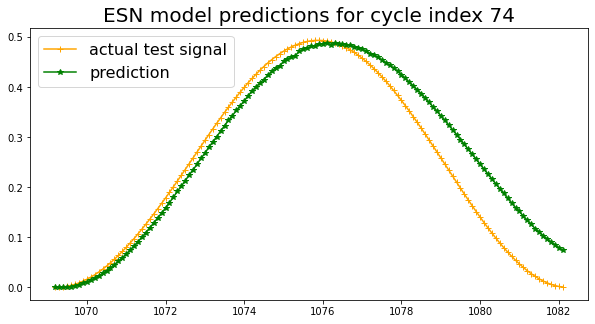

In [ ]:
plot_predictions(predictions=predictions_esn, ytest=ytest_esn, 
                title="ESN model predictions for cycle index {}".format(predict_cycle_num))

#ytest_un = np.copy(ytest)
#ytest_un[:,-1] = unnormalize(ytest[:,-1], Xmax, Xmin)
#plot_predictions(predictions=unnormalize(predictions_esn, Xmax, Xmin), ytest=ytest_un, 
#                title="ESN model predictions (unnormalized) for cycle index {}".format(predict_cycle_num))

## Loading the data for training the RNN models

### Obtain the data and targets by heuristically setting the number of taps

The variable `num_taps` decides the number of 'past' values used by the RNN model for predicting a single 
prediction

In [ ]:
num_taps_rnn = 32
output_size_tau = 1
X, Y = get_msah_training_dataset(data, minimum_idx=minimum_idx, tau = output_size_tau, p=num_taps_rnn)

### Get xtrain, ytrain, ytest for predicting the cycle index 74 (75th cycle). 

*NOTE:* The dynamo dataset consists of 77 cycles (indexed from 0 to 76). In case `predict_cycle_num` is equal to 76 (i.e. number of total cycles - 1), the future cycle would be predicted because no data is currently available.

In [ ]:
predict_cycle_num = 74
xtrain, ytrain, ytest = get_cycle(X, Y, idx=predict_cycle_num)

`xtrain` is now a list containing all the inputs data up to the start of cycle 74.
`ytrain` contains the targets associated with these inputs.
`ytest` contains the 74th cycle itself required for validation.

Apply `concat_data` to concatenate the inputs and keep only the signals (i.e. not the timestamp). We also add an extra dimension required to have the data used as input to torch models.

In [ ]:
train_data_inputs, train_data_targets = concat_data(xtrain), concat_data(ytrain) 

if len(train_data_inputs.shape) == 2:
    # Extra dimension to be added
    N, P = train_data_inputs.shape
    train_data_inputs = train_data_inputs.reshape((N, P, 1))

In [ ]:
train_data_inputs.shape

(10660, 32, 1)

Split the training data into a training and validation set. We use 90 % of the data for training and 10 % for validation

In [ ]:
tr_inputs, tr_targets, val_inputs, val_targets = train_validation_split(
    train_data_inputs, train_data_targets, tr_split=0.9)


Check the sizes of the generated training and testing data

## Resulting dataset

In this section we investigate the sizes of the generated training and testing datasets.

In [ ]:
print("training inputs shape\t", tr_inputs.shape)
print("training targets shape\t", tr_targets.shape)

training inputs shape	 torch.Size([9594, 32, 1])
training targets shape	 torch.Size([9594, 1])


One row of the input data consists to `num_taps` consecutive time series samples.
The corresponding row in the training target consist in the next time series sample.
This means that the target for the first input, is the last data point of the second input.

In [ ]:
print("First target:\t\t\t",tr_targets[0])
print("Last sample of second input:\t",tr_inputs[1][-1])

First target:			 tensor([0.0085])
Last sample of second input:	 tensor([0.0085])


## Defining the Model

### Define the RNN model class

This class defines the RNN model used for fitting on the time-series data

**Tasks:** 
- Following the PyTorch documentation for RNN, LSTM and GRU (as provided in the references), initialise the value of `self.rnn` for the class `RNN_model`. The procedure on how to initialise the network for an RNN has been shown. Complete the code block for LSTM, GRU. Pay attention to the shape of the inputs and outputs to the RNN
- Insert a *fully-connected* linear layer that takes the RNN output and returns the prediction to be compared with the target.
- Complete the forward function. *Hint:* The forward function takes the output of the RNN at the *last time-step* and passses it to the fully connected layer 

In [ ]:
# Create an RNN model for prediction
class RNN_model(nn.Module):
    """ This super class defines the specific model to be used i.e. LSTM or GRU or RNN
    """
    def __init__(self, input_size, output_size, n_hidden, n_layers, 
        model_type, lr, num_epochs, num_directions=1, batch_first = True):
        super(RNN_model, self).__init__()
        """
        Args:
        - input_size: The dimensionality of the input data
        - output_size: The dimensionality of the output data
        - n_hidden: The size of the hidden layer, i.e. the number of hidden units used
        - n_layers: The number of hidden layers
        - model_type: The type of modle used ("lstm"/"gru"/"rnn")
        - lr: Learning rate used for training
        - num_epochs: The number of epochs used for training
        - num_directions: Parameter for bi-directional RNNs (usually set to 1 in this case, for bidirectional set as 2)
        - batch_first: Option to have batches with the batch dimension as the starting dimension 
        of the input data
        """
        # Defining some parameters
        self.hidden_dim = n_hidden  
        self.num_layers = n_layers
        self.input_size = input_size
        self.output_size = output_size
        
        self.model_type = model_type
        self.lr = lr
        self.num_epochs = num_epochs
        
        # Predefined:
        ## Use only the forward direction 
        self.num_directions = 1
        
        ## The input tensors must have shape (batch_size,...)
        self.batch_first = True
        
        # Defining the recurrent layers 
        if model_type.lower() == "rnn": # RNN 
            self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_dim, 
                num_layers=self.num_layers, batch_first=self.batch_first)   
        elif model_type.lower() == "lstm": # LSTM
            self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_dim, 
                num_layers=self.num_layers, batch_first=self.batch_first)
        elif model_type.lower() == "gru": # GRU
            self.rnn = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_dim, 
                num_layers=self.num_layers, batch_first=self.batch_first)  
        else:
            print("Model type unknown:", model_type.lower()) 
            sys.exit() 
        
        # Fully connected layer to be used for mapping the output
        self.fc = nn.Linear(self.hidden_dim * self.num_directions, self.output_size)
    
    def init_h0(self, batch_size):
        """ This function defines the initial hidden state of the RNN
        """
        # This method generates the first hidden state of zeros (h0) which is used in the forward pass
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        return h0
    
    def forward(self, x):
        """ This function defines the forward function to be used for the RNN model
        """
        batch_size = x.shape[0]
        
        # Obtain the RNN output
        r_out, hn_all = self.rnn(x)
        
        # Reshaping the output appropriately
        r_out = r_out.contiguous().view(batch_size, -1, self.num_directions, self.hidden_dim)
        
        # Select the last time-step
        r_out = r_out[:, -1, :, :]
        r_out_last_step = r_out.reshape((-1, self.hidden_dim))
        
        # Passing the output to the fully connected layer
        y = self.fc(r_out_last_step)
        return y

### Define the model configuration options

A single dictionary named `options` consists of the model and training parameters for all the various RNN models. To understand what each option means refer to the documentation of `nn.RNN`, `nn.LSTM` and `nn.GRU`.

In [ ]:
options = {
"lstm":{
    "input_size":1,
    "output_size":len(ytest),
    "n_hidden":40,
    "n_layers":2,
    "model_type":"lstm",
    "lr":1e-2,
    "num_epochs":300
},

}

### Train using RNN models

This function describes the training procedure using the chosen RNN model.
An step-wise decaying learning rate is used to aid the training for deeper networks.

- Task: Complete the training loop. This includes:
  - The forward pass
  - Calculating the loss using the criterion
  - Backpropagation
  - Updating the weights

Use something like the standard code that you have used in previous exercises so far


In [ ]:
def train_rnn(model, nepochs, tr_inputs, tr_targets, val_inputs, val_targets, tr_verbose=True):
    """ This function implements the training algorithm for the RNN model

    Args:
    - model: object of the `RNN_Model` class
    - tr_inputs: Training data inputs of dimension (N_train_samples x num_taps x input_size)
    - tr_outputs: Training targets of dimension (N_train_samples x output_size)
    - val_inputs: Validation data inputs of dimension (N_val_samples x num_taps x input_size)
    - val_targets: Validation targets of dimension (N_val_samples x output_size)
    - tr_verbose: 'Flag' to view training progress

    Returns:
    - losses: Training losses
    - val_losses: Validation losses
    - model: trained model
    """
    optimizer = optim.Adam(model.parameters(), lr=model.lr)
    criterion = nn.MSELoss()
    losses = []
    val_losses = []
    model.train()

    for epoch in range(nepochs):
        
        optimizer.zero_grad()
        X = Variable(tr_inputs, requires_grad=False).type(torch.FloatTensor).to(device)
        
        # Write your code here
        tr_predictions = model.forward(X)
        tr_loss = criterion(tr_predictions, tr_targets.to(device))
        tr_loss.backward()
        optimizer.step()
        
        losses.append(tr_loss.item())

        with torch.no_grad():
            
            X_val = Variable(val_inputs, requires_grad=False).type(torch.FloatTensor).to(device)
            val_predictions = model.forward(X_val)
            val_loss = criterion(val_predictions, val_targets.to(device))
            val_losses.append(val_loss.item())

        if tr_verbose == True and (((epoch + 1) % 50) == 0 or epoch == 0):
            print("Epoch: {}/{}, Training MSE Loss:{:.9f}, Val. MSE Loss:{:.9f} ".format(epoch+1, 
            model.num_epochs, tr_loss, val_loss))

    return losses, val_losses, model


### Predict using RNN models

This function describes the prediction algorithm using the trained RNN model. The RNN uses its own predictions to eventually constitute the input in future cycles.

**Task**: 
- Complete the `predict_rnn` function by modifying `eval_input` so that in each iteration, the *test* prediction is appended to the end of the input, after it has been left-shifted. 
    *Hint:* Use `np.roll( )` to left the shift `eval_input` by a value equal to the model's output size (as for every input sample, the model predicts a single model predicts `output_size` number of values)
   
- The predictions are appended in a list. Finally convert them into a numpy array.

In [ ]:
def predict_rnn(model, eval_input, n_predict):
    """ This function defines the prediction algorithm. The predictions of the RNN model
    are subsequently used as inputs for future predictions, i.e. eventually the test input 
    becomes composed of the predictions of the RNN.

    Args:
    - model: The trained model
    - eval_input: The last sample of the training data (before val. split) input used as the starting 
    input for predicting the test set samples
    - n_predict: The number of values to predict for the test data cycle

    Returns:
    - eval_predictions: The test set predictions as a numpy array
    """
    eval_predictions = []
    model.eval()
    with torch.no_grad():

        for _ in range(n_predict):
            
            X_eval = Variable(torch.Tensor(eval_input), requires_grad=False).type(torch.FloatTensor).to(device)
            eval_prediction = model.forward(X_eval)
            eval_predictions.append(eval_prediction.cpu().numpy())

            # Left shifting the input array to include predictions
            # Insert Code here
            eval_input = np.roll(eval_input, shift=-model.output_size) 
            if eval_input.shape[1] is not None:
                eval_input[:, -model.output_size] = eval_prediction.cpu().numpy()
            else:
                eval_input[-model.output_size] = eval_prediction.cpu().numpy()
    
    # Combine the predictions in a single numpy array. Use np.row_stack()
    eval_predictions = np.row_stack(eval_predictions)
    return eval_predictions

## Selecting the model to be used

In [ ]:
#model_type = "gru"   #  "gru", "rnn", or "lstm"
options = {
    "model_type":"gru",
    "input_size":1,
    "output_size":output_size_tau,
    "n_hidden":50,
    "n_layers":2,
    "lr":1e-3,
    "num_epochs":800
}
model_gru = RNN_model(**options).to(device)

In [ ]:
print(model_gru)

RNN_model(
  (rnn): GRU(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


## Running the training algorithm and generating predictions

In [ ]:
# To decide the level of output logs
tr_verbose = True  
tr_losses, val_losses, model_gru = train_rnn(model=model_gru, nepochs=model_gru.num_epochs, 
                                         tr_inputs=tr_inputs, tr_targets=tr_targets, 
                                         val_inputs=val_inputs, val_targets=val_targets, 
                                         tr_verbose=tr_verbose)

Epoch: 1/800, Training MSE Loss:0.180266678, Val. MSE Loss:0.188955083 
Epoch: 50/800, Training MSE Loss:0.001724268, Val. MSE Loss:0.002425252 
Epoch: 100/800, Training MSE Loss:0.000701574, Val. MSE Loss:0.000921146 
Epoch: 150/800, Training MSE Loss:0.000473378, Val. MSE Loss:0.000620270 
Epoch: 200/800, Training MSE Loss:0.000306382, Val. MSE Loss:0.000397530 
Epoch: 250/800, Training MSE Loss:0.000137812, Val. MSE Loss:0.000172842 
Epoch: 300/800, Training MSE Loss:0.000028293, Val. MSE Loss:0.000030566 
Epoch: 350/800, Training MSE Loss:0.000015299, Val. MSE Loss:0.000015977 
Epoch: 400/800, Training MSE Loss:0.000013252, Val. MSE Loss:0.000013619 
Epoch: 450/800, Training MSE Loss:0.000011611, Val. MSE Loss:0.000011775 
Epoch: 500/800, Training MSE Loss:0.000010250, Val. MSE Loss:0.000010260 
Epoch: 550/800, Training MSE Loss:0.000009026, Val. MSE Loss:0.000008913 
Epoch: 600/800, Training MSE Loss:0.000007860, Val. MSE Loss:0.000007645 
Epoch: 650/800, Training MSE Loss:0.00000

Plotting the training the validation losses versus number of training iterations

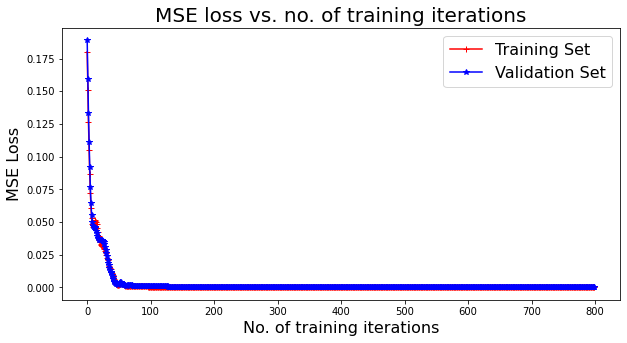

In [ ]:
if tr_verbose == True:
    plot_losses(tr_losses=tr_losses, val_losses=val_losses, logscale=False)

## Obtain the predictions using trained GRU model

The predictions are obtained by passing the last sample of the `training_data_inputs`. Think about the shape of the variable `training_data_inputs`, and why the final value is passed as `eval_input`.

In [ ]:

if len(ytest) > 0:     # In case the 'future' cycle is still within the dataset
    
    # Predict the full next known cycle
    predictions_gru = predict_rnn(model=model_gru, eval_input=train_data_inputs[-1, :, :].reshape((1, P, -1)), 
                               n_predict=len(ytest))
    
    # Write your code here
    test_error_gru = mean_squared_error(y_true=ytest[:, -1], y_pred=predictions_gru)

else:
    # In case the 'future' cycle is beyond the dataset
    
    #NOTE: Heuristically setting the number of future predictions
    predictions_gru = predict_rnn(model=model_gru, eval_input=train_data_inputs[-1, :, :].reshape((1, P, -1)), 
                                  n_predict=132)
    test_error_gru = np.nan # No reference to compare for genearting Test error

tr_error = tr_losses[-1] # latest training error
val_error = val_losses[-1] # latest validation error

In [ ]:
print("Test error using GRU:{}".format(test_error_gru))

Test error using GRU:0.002199476690735845


### Visualizing predictions for the GRU model

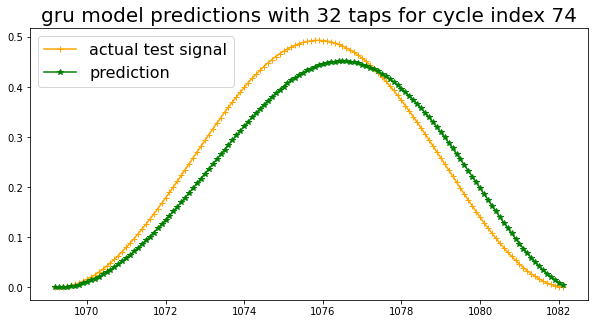

In [ ]:
if len(ytest) > 0:
    # In case the 'future' cycle is still within the dataset
    
    # Normalized predictions in [0, 1]
    plot_predictions(predictions=predictions_gru, ytest=ytest, 
                     title="{} model predictions with {} taps for cycle index {}".format(
                         "gru", num_taps_rnn, predict_cycle_num))

else:
    # In case the 'future' cycle is beyond the dataset
    
    # Normalized predictions in [0, 1]
    plot_future_predictions(data=data, minimum_idx=minimum_idx, ytrain=ytrain, predictions=predictions_gru,
    title="Plot of original timeseries and future predictions for {} for cycle index {}".format(
        model_type, predict_cycle_num))

## Running training and predictions for LSTM model

**Tasks**: 
- Select "lstm" as one of the options and load the appropriate model
- Similar to the GRU model:
    - Train an LSTM model by calling `train_rnn` function. Experiment with hyperparameters if necessary.
    - Obtain the predictions by calling `predict_rnn`
- Compare the predictions using LSTM and GRUs

In [ ]:
options_lstm= {
    "input_size":1,
    "output_size":output_size_tau,
    "n_hidden":50,
    "n_layers":2,
    "model_type":"lstm",
    "lr":1e-3,
    "num_epochs":800
}
model_lstm = RNN_model(**options_lstm).to(device)
print(model_lstm)

RNN_model(
  (rnn): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
# To decide the level of output logs
tr_verbose = True
tr_losses_lstm, val_losses_lstm, model_lstm = train_rnn(model=model_lstm, nepochs=model_lstm.num_epochs, 
                                         tr_inputs=tr_inputs, tr_targets=tr_targets, 
                                         val_inputs=val_inputs, val_targets=val_targets, 
                                         tr_verbose=tr_verbose)

Epoch: 1/800, Training MSE Loss:0.141302273, Val. MSE Loss:0.161024168 
Epoch: 50/800, Training MSE Loss:0.009457939, Val. MSE Loss:0.010842412 
Epoch: 100/800, Training MSE Loss:0.002161628, Val. MSE Loss:0.002603555 
Epoch: 150/800, Training MSE Loss:0.000200082, Val. MSE Loss:0.000210998 
Epoch: 200/800, Training MSE Loss:0.000059756, Val. MSE Loss:0.000061846 
Epoch: 250/800, Training MSE Loss:0.000041644, Val. MSE Loss:0.000042177 
Epoch: 300/800, Training MSE Loss:0.000034254, Val. MSE Loss:0.000034223 
Epoch: 350/800, Training MSE Loss:0.000029873, Val. MSE Loss:0.000029890 
Epoch: 400/800, Training MSE Loss:0.000026647, Val. MSE Loss:0.000026847 
Epoch: 450/800, Training MSE Loss:0.000024076, Val. MSE Loss:0.000024472 
Epoch: 500/800, Training MSE Loss:0.000022127, Val. MSE Loss:0.000022658 
Epoch: 550/800, Training MSE Loss:0.000020032, Val. MSE Loss:0.000020885 
Epoch: 600/800, Training MSE Loss:0.000018319, Val. MSE Loss:0.000019314 
Epoch: 650/800, Training MSE Loss:0.00001

In [ ]:
## Obtain the predictions using trained LSTM model
if len(ytest) > 0:
    # In case the 'future' cycle is still within the dataset
    #with torch.no_grad():
    #    xtest = train_data_inputs[-1, :, :].reshape((1, P, -1))
    #    xtest = Variable(torch.Tensor(xtest), requires_grad=False).type(torch.FloatTensor).to(device)
    #    predictions_lstm = model_lstm.forward(xtest).reshape((-1, 1))
    predictions_lstm = predict_rnn(model=model_lstm, eval_input=train_data_inputs[-1, :, :].reshape((1, P, -1)), 
                                  n_predict=len(ytest))
    test_error_lstm = mean_squared_error(y_true=ytest[:, -1], y_pred=predictions_lstm)

else:
    # In case the 'future' cycle is beyond the dataset
    #NOTE: Needs to be fixed!!
    #NOTE: Heuristically setting the number of future predictions
    #xtest = train_data_inputs[-1, :, :].reshape((1, P, -1))
    #xtest = Variable(torch.Tensor(xt), requires_grad=False).type(torch.FloatTensor).to(device)
    #predictions_lstm = model_gru.forward(xtest).reshape((-1, 1))
    predictions_lstm = predict_rnn(model=model_lstm, eval_input=train_data_inputs[-1, :, :].reshape((1, P, -1)), 
                                  n_predict=132)
    test_error_lstm = np.nan # No reference to compare for genearting Test error

tr_error = tr_losses_lstm[-1] # latest training error
val_error = val_losses_lstm[-1] # latest validation error

In [ ]:
print("Test error using LSTM:{}".format(test_error_lstm))

Test error using LSTM:0.005520575719016473


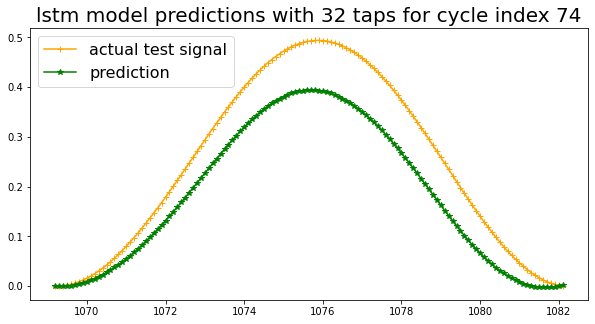

In [ ]:
# Visualise the predictions
if len(ytest) > 0:
    # In case the 'future' cycle is still within the dataset
    
    # Normalized predictions in [0, 1]
    plot_predictions(predictions=predictions_lstm, ytest=ytest, 
                     title="{} model predictions with {} taps for cycle index {}".format(
                         "lstm", num_taps_rnn, predict_cycle_num))

else:
    # In case the 'future' cycle is beyond the dataset
    
    # Normalized predictions in [0, 1]
    plot_future_predictions(data=data, minimum_idx=minimum_idx, ytrain=ytrain, predictions=predictions_lstm,
                title="Plot of original timeseries and future predictions for {} for cycle index {}".format(
                "lstm", predict_cycle_num))
    
    

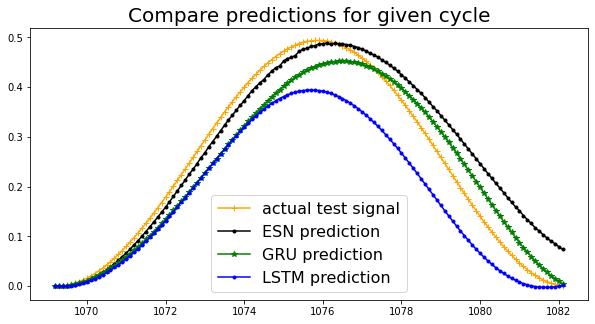

In [ ]:
# Plot the LSTM, GRU predictions
plt.figure(figsize=(10,5))
plt.title("Compare predictions for given cycle", fontsize=20)
plt.plot(ytest[:,0], ytest[:,1], '+-', label="actual test signal", color="orange")
plt.plot(ytest[:,0], predictions_esn, '.-', label="ESN prediction", color="black")
plt.plot(ytest[:,0], predictions_gru, '*-', label="GRU prediction", color="green")
plt.plot(ytest[:,0], predictions_lstm, '.-', label="LSTM prediction", color="blue")
plt.legend(fontsize=16)
plt.show()

Using some additional metrics for comparison between the models such MAE, R2_Score

In [ ]:
import pandas as pd
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

def compute_metric(actual_y, pred_y, type):
    
    if type == 'mse':
        return mean_squared_error(actual_y, pred_y)
    elif type == 'mae':
        return mean_absolute_error(actual_y, pred_y)
    elif type == 'r2':
        return r2_score(actual_y, pred_y)

pred_dicts = {
        "actual":ytest[:, 1],
        "esn":predictions_esn,
        "lstm":predictions_lstm,
        "gru":predictions_gru
    }
    
df_metrics = []
for model_name in ["esn", "lstm", "gru"]:
    df_metrics.append([model_name, 
                      compute_metric(pred_dicts["actual"], pred_dicts[model_name], type="mse"),
                      compute_metric(pred_dicts["actual"], pred_dicts[model_name], type="mae"),
                      compute_metric(pred_dicts["actual"], pred_dicts[model_name], type="r2"),
                      ])

metrics_columns = ["Model_Name", "Test MSE", "Test MAE", "Test R2"]
df_compare_metrics = pd.DataFrame(df_metrics, columns=metrics_columns)


In [ ]:
# See the scores on a dataframe
df_compare_metrics

,Model_Name,Test MSE,Test MAE,Test R2
0,esn,0.002989,0.040993,0.901685
1,lstm,0.005521,0.065101,0.818432
2,gru,0.002199,0.040370,0.927661


**Additional Tasks**: 

- Try to tune the model hyperparameters for LSTM to see if a better result can be obtained for the given model prediction. Insert some new code after this part, by reusing the existing code and experiment with the 
model `options` such `n_layers` or `n_hidden`, etc.

- *(Optional)* **Checking the variance of the predictions**: 
Try to simulate the GRU and LSTM models training many times (set the verbosity flag to False), and plot a figure that shows how the mean prediction across the number of simulations and the standard deviation of the predictions. Compare it with the actual test prediction. This would give an idea of how consistent the training of such complex models are.

In [ ]:
# Insert Codes here
# ...
# ...